In [37]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import numpy as np

In [38]:
import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import networkx as nx
from collections import OrderedDict
from itertools import combinations
import math
from tqdm import tqdm
import logging

In [82]:
import os
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import logging
import random
import torch.nn.functional as F

In [39]:
df = pd.read_csv('./train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [40]:
# take the first 1000 data points due to memory constraints
df=df.loc[0:999]

In [41]:
df.shape

(1000, 5)

In [42]:
df.drop(columns=['id','keyword','location'],inplace=True)

<Figure size 576x432 with 0 Axes>

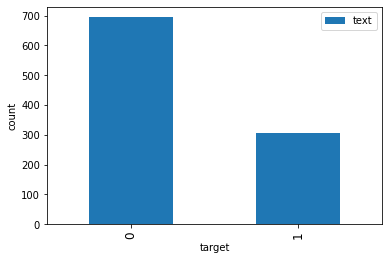

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('target').count().plot.bar(ylim=0)
plt.xticks(fontsize=12)
plt.ylabel('count')
plt.show()

In [44]:
# text cleaning

from nltk.stem import WordNetLemmatizer
import nltk
from textblob import TextBlob 
from tqdm.notebook import tqdm

tqdm.pandas()
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

proc_df = pd.DataFrame()
def pre_process(text):
    #remove url
    text = re.sub(r'http\S+', '', text)
    #remove special characters
    text = re.sub('\W', ' ', text)
    #remove digits
    text = re.sub(r'\d+', '', text)
    #remove underline
    text = re.sub(r'_',' ', text)  
    #remove white spaces
    text = re.sub(r'\s+',' ', text)
    #to lower
    text = text.lower()
    #correct typos
    # text = str(TextBlob(text).correct())

    #remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stop_words)])
    #lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
        # remove single letters
    text = ' '.join(i for i in text.split() if not (i.isalpha() and len(i)==1))
    return text



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [45]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [46]:
proc_df['text'] = df['text'].progress_apply(lambda text: pre_process(text))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
proc_df['target']=df['target']
proc_df.head()

,text,target
0,deed reason earthquake may allah forgive,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


In [48]:
df_data = proc_df.copy()

In [49]:
### Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(input="content", max_features=None, tokenizer=None, stop_words=None)
vectorizer.fit(df_data["text"])
df_tfidf = vectorizer.transform(df_data["text"])
df_tfidf = df_tfidf.toarray()
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)
df_tfidf = pd.DataFrame(df_tfidf,columns=vocab)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [50]:
import nltk
nltk.download('punkt')
def filter_tokens(tokens, stopwords):
    tokens1 = []
    for token in tokens:
        if (token not in stopwords) and (token not in [".",",",";","&","'s", ":", "?", "!","(",")",\
            "'","'m","'no","***","--","...","[","]",'wan','ta','lem','na']):
            tokens1.append(token)
    return tokens1

stopwords = list(set(nltk.corpus.stopwords.words("english")))

df_data["text"] = df_data["text"].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: filter_tokens(x, stopwords))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
### PMI between words
window = 3 # sliding window size to calculate point-wise mutual information between words
names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )
occurrences = np.zeros( (len(names),len(names)) ,dtype=np.int32)

# Find the co-occurrences:
no_windows = 0
for l in tqdm(df_data["text"], total=len(df_data["text"])):
    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])

        for w in d:
            n_i[w] += 1
        for w1,w2 in combinations(d,2):
            i1 = word2index[w1]
            i2 = word2index[w2]

            occurrences[i1][i2] += 1
            occurrences[i2][i1] += 1

### convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
p_ij = p_ij + 1E-9
for col in p_ij.columns:
    p_ij[col] = p_ij[col].apply(lambda x: math.log(x))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
# build graph

def nCr(n,r):
    f = math.factorial
    return int(f(n)/(f(r)*f(n-r)))
    
def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns); cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word

### Build graph
G = nx.Graph()
G.add_nodes_from(df_tfidf.index) ## document nodes
G.add_nodes_from(vocab) ## word nodes
### build edges between document-word pairs
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in df_tfidf.index for w in df_tfidf.columns]
G.add_edges_from(document_word)
### build edges between word-word pairs
word_word = word_word_edges(p_ij)
G.add_edges_from(word_word)

  0%|          | 0/6242811 [00:00<?, ?it/s]

#**Build GNN**

In [79]:
import logging
logging.basicConfig(format='%(asctime)s [%(levelname)s]: %(message)s', \
                    datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)
logger = logging.getLogger()



In [80]:
# train test split

A = nx.to_numpy_matrix(G, weight="weight"); A = A + np.eye(G.number_of_nodes())
degrees = []
for d in G.degree(weight=None):
    if d == 0:
        degrees.append(0)
    else:
        degrees.append(d[1]**(-0.5))
degrees = np.diag(degrees)
X = np.eye(G.number_of_nodes()) # Features are just identity matrix
A_hat = degrees@A@degrees
f = X # (n X n) X (n X n) x (n X n) X (n X n) input of net

logger.info("Splitting labels for training and inferring...")
### stratified test samples
test_idxs = random.sample(range(0, 1000), 250)

# select only certain labelled nodes for semi-supervised GCN
selected = []
for i in range(len(df_data)):
    if i not in test_idxs:
        selected.append(i)

f_selected = f[selected]; f_selected = torch.from_numpy(f_selected).float()
labels_selected = [l for idx, l in enumerate(df_data["target"]) if idx in selected]
f_not_selected = f[test_idxs]; f_not_selected = torch.from_numpy(f_not_selected).float()
labels_not_selected = [l for idx, l in enumerate(df_data["target"]) if idx not in selected]
f = torch.from_numpy(f).float()
logger.info("Split into %d train and %d test lebels." % (len(labels_selected), len(labels_not_selected)))

04/19/2022 03:56:01 AM [INFO]: Splitting labels for training and inferring...
04/19/2022 03:56:02 AM [INFO]: Split into 750 train and 250 test lebels.


In [89]:
# parameters for gnn

hidden_size_1=330
hidden_size_2=130
num_classes=2
num_epochs=1000
lr=0.011

In [119]:
# define gnn model

class gcn(nn.Module):
    def __init__(self, X_size, A_hat, hidden_size_1,hidden_size_2,num_classes, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.A_hat = torch.tensor(A_hat, requires_grad=False).float()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, hidden_size_1))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(hidden_size_1, hidden_size_2))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(hidden_size_1))
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(hidden_size_2))
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(hidden_size_2, num_classes) # output layer with no. of classes node
        
    def forward(self, X): ### 2-layer GCN architecture
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
        X = F.relu(torch.mm(self.A_hat, X))
        X = torch.mm(X, self.weight2)
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(self.A_hat, X))
        return self.fc1(X)


  

In [132]:
# evaluation of accuracy
def evaluate(output, labels_e):
    _, labels = output.max(1); labels = labels.numpy()
    return sum([e for e in labels_e] == labels)/len(labels)

In [134]:
# train gnn model
net = gcn(X.shape[1], A_hat, hidden_size_1,hidden_size_2,num_classes)
criterion = nn.CrossEntropyLoss() # binary cross entropy loss
optimizer = optim.Adam(net.parameters(), lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,3000,4000,5000,6000], gamma=0.77)

start_epoch, best_pred = 0,0
losses_per_epoch, evaluation_untrained = [],[]

logger.info("Starting training process...")
net.train()
evaluation_trained = []
for e in range(start_epoch, num_epochs):
    optimizer.zero_grad()
    output = net(f)
    loss = criterion(output[selected], torch.tensor(labels_selected).long())
    losses_per_epoch.append(loss.item())
    loss.backward()
    optimizer.step()
    if e % 50 == 0:
        ### Evaluate other untrained nodes and check accuracy of labelling
        net.eval()
        with torch.no_grad():
            pred_labels = net(f)
            trained_accuracy = evaluate(output[selected], labels_selected); untrained_accuracy = evaluate(pred_labels[test_idxs], labels_not_selected)
        evaluation_trained.append((e, trained_accuracy)); evaluation_untrained.append((e, untrained_accuracy))
        print("[Epoch %d]: Evaluation accuracy of trained nodes: %.7f" % (e, trained_accuracy))
        print("[Epoch %d]: Evaluation accuracy of test nodes: %.7f" % (e, untrained_accuracy))
        # print("Labels of trained nodes: \n", output[selected].max(1)[1])
        net.train()
        if trained_accuracy > best_pred:
            best_pred = trained_accuracy
            # torch.save({
            #     'epoch': e + 1,\
            #     'state_dict': net.state_dict(),\
            #     'best_acc': trained_accuracy,\
            #     'optimizer' : optimizer.state_dict(),\
            #     'scheduler' : scheduler.state_dict(),\
            # }, os.path.join("./data/" ,\
            #     "test_model_best_%d.pth.tar" % args.model_no))
    
    scheduler.step()
    
logger.info("Finished training!")

04/19/2022 07:17:35 AM [INFO]: Starting training process...


[Epoch 0]: Evaluation accuracy of trained nodes: 0.6986667
[Epoch 0]: Evaluation accuracy of test nodes: 0.6840000
[Epoch 50]: Evaluation accuracy of trained nodes: 0.6986667
[Epoch 50]: Evaluation accuracy of test nodes: 0.6840000
[Epoch 100]: Evaluation accuracy of trained nodes: 0.6986667
[Epoch 100]: Evaluation accuracy of test nodes: 0.6840000
[Epoch 150]: Evaluation accuracy of trained nodes: 0.9333333
[Epoch 150]: Evaluation accuracy of test nodes: 0.5720000
[Epoch 200]: Evaluation accuracy of trained nodes: 0.9600000
[Epoch 200]: Evaluation accuracy of test nodes: 0.5760000
[Epoch 250]: Evaluation accuracy of trained nodes: 0.9680000
[Epoch 250]: Evaluation accuracy of test nodes: 0.5760000
[Epoch 300]: Evaluation accuracy of trained nodes: 0.9706667
[Epoch 300]: Evaluation accuracy of test nodes: 0.5880000
[Epoch 350]: Evaluation accuracy of trained nodes: 0.9746667
[Epoch 350]: Evaluation accuracy of test nodes: 0.6080000
[Epoch 400]: Evaluation accuracy of trained nodes: 0.9

04/19/2022 07:27:19 AM [INFO]: Finished training!


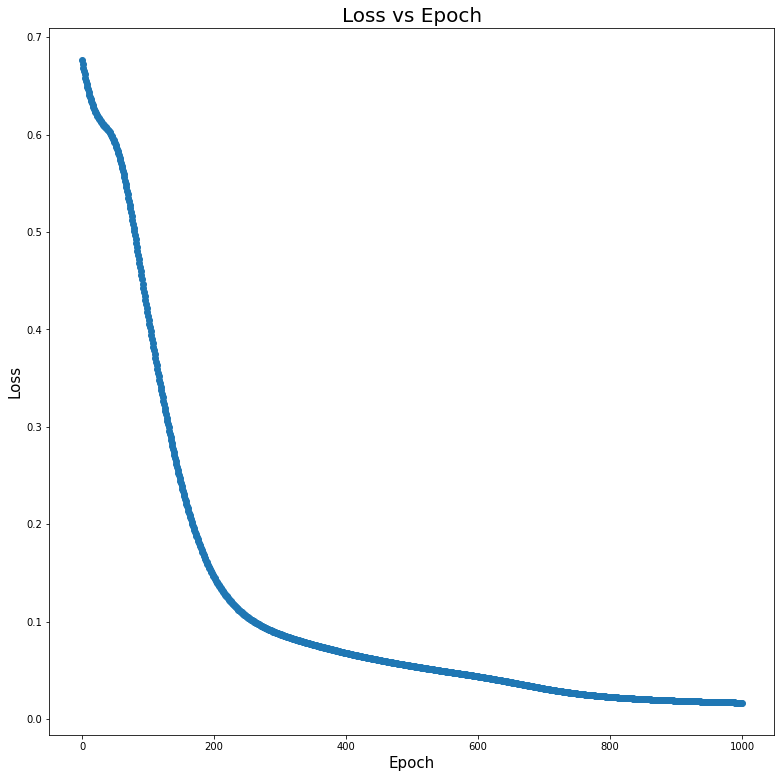

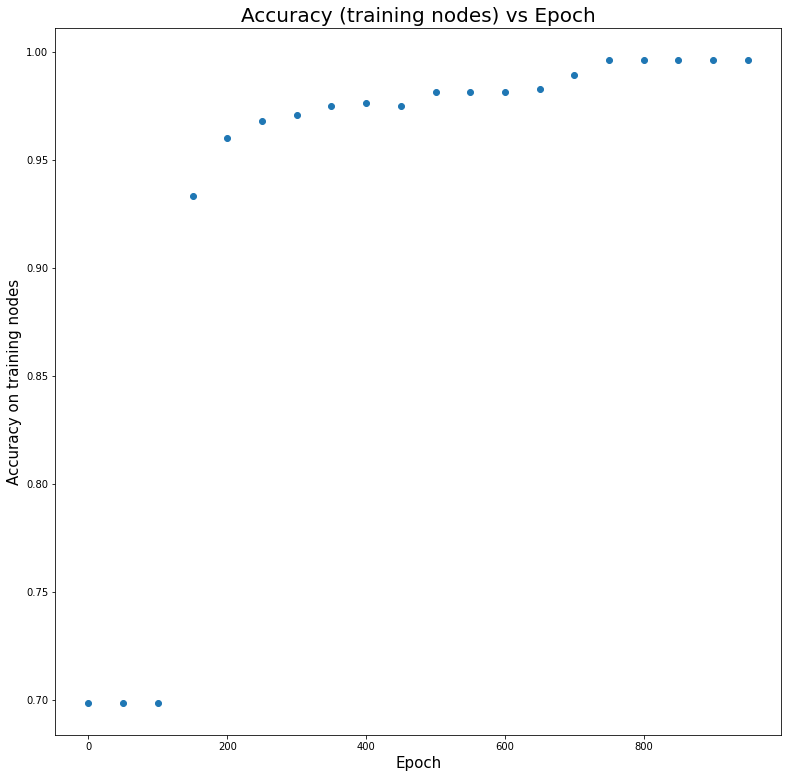

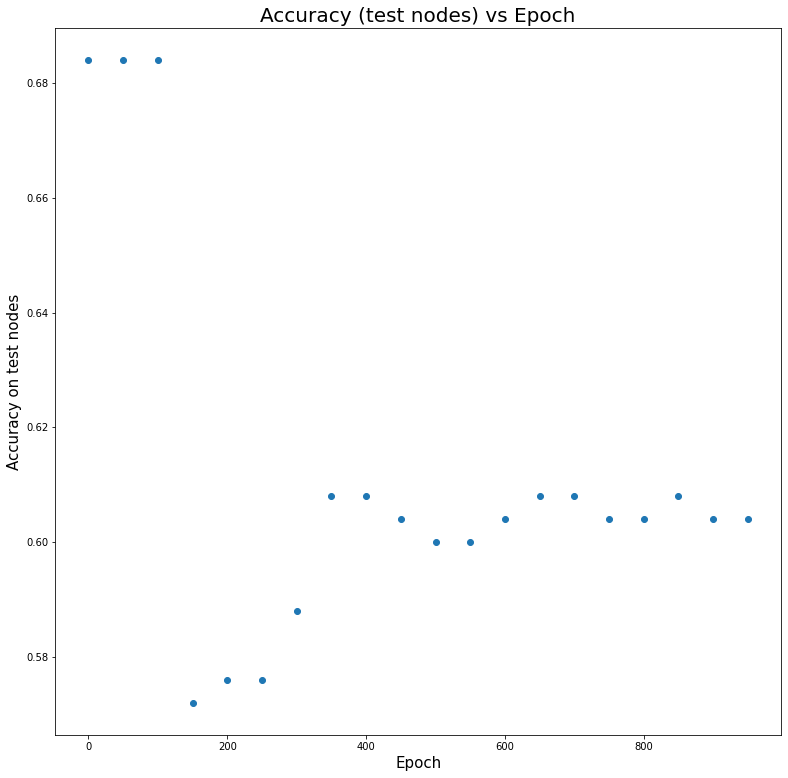

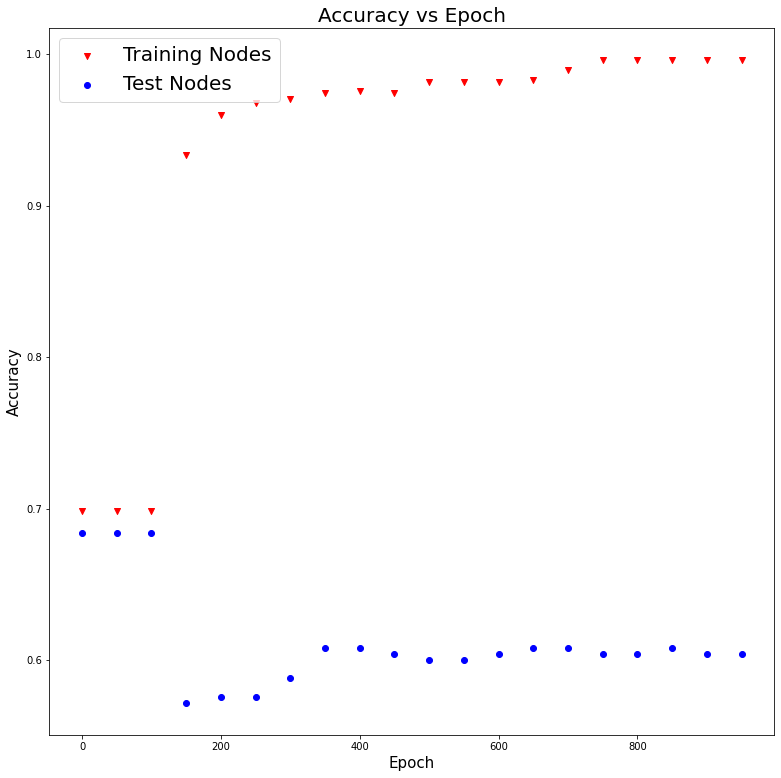

In [144]:
# plot evaluation results

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter([i for i in range(len(losses_per_epoch))], losses_per_epoch)
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.set_title("Loss vs Epoch", fontsize=20)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter(np.array(evaluation_trained)[:,0], np.array(evaluation_trained)[:,1])
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy on training nodes", fontsize=15)
ax.set_title("Accuracy (training nodes) vs Epoch", fontsize=20)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter(np.array(evaluation_untrained)[:,0], np.array(evaluation_untrained)[:,1])
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy on test nodes", fontsize=15)
ax.set_title("Accuracy (test nodes) vs Epoch", fontsize=20)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter(np.array(evaluation_trained)[:,0], np.array(evaluation_trained)[:,1], c="red", marker="v", \
            label="Training Nodes")
ax.scatter(np.array(evaluation_untrained)[:,0], np.array(evaluation_untrained)[:,1], c="blue", marker="o",\
            label="Test Nodes")
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_title("Accuracy vs Epoch", fontsize=20)
ax.legend(fontsize=20)